In [2]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from tqdm import tqdm
import gc
from scipy import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def split_cat(text):
    try:
        return text.split("/")
    except:
        return ("No Label", "No Label", "No Label")

In [5]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML project/train.tsv', sep='\t', 
                      dtype={'item_condition_id': 'category', 'shipping': 'category'}, 
                      converters={'category_name': split_cat})
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML project/test.tsv', sep='\t', 
                     dtype={'item_condition_id': 'category', 'shipping': 'category'}, 
                     converters={'category_name': split_cat})

In [6]:
print('Shape of train data: ', train.shape)
print('Shape of test data: ', test.shape)
test[test.id == 17]

Shape of train data:  (1037774, 8)
Shape of test data:  (444761, 7)


,id,name,item_condition_id,category_name,brand_name,shipping,item_description
87057,17,New: Baby K'tan active baby carrier,1,"[Kids, Gear, Backpacks & Carriers]",NaN,1,Brand new in box Size: Medium Color: Coral Ret...


In [7]:
train[train.train_id == 8]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
93039,8,Girls Nike Pro shorts,3,"[Sports & Outdoors, Apparel, Girls]",Nike,19.0,0,Girls Size small Plus green. Three shorts total.


In [8]:
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [9]:
test.isnull().any()

id                   False
name                 False
item_condition_id    False
category_name        False
brand_name            True
shipping             False
item_description      True
dtype: bool

In [10]:
# Split category_name by '/' into subcategories and replace nulls with 'missing'
train['gencat_name'] = train['category_name'].str.get(0).replace('', 'missing').astype('category')
train['subcat1_name'] = train['category_name'].str.get(1).fillna('missing').astype('category')
train['subcat2_name'] = train['category_name'].str.get(2).fillna('missing').astype('category')
train.drop('category_name', axis=1, inplace=True)

# Split category_name by '/' into subcategories and replace nulls with 'missing'
test['gencat_name'] = test['category_name'].str.get(0).replace('', 'missing').astype('category')
test['subcat1_name'] = test['category_name'].str.get(1).fillna('missing').astype('category')
test['subcat2_name'] = test['category_name'].str.get(2).fillna('missing').astype('category')
test.drop('category_name', axis=1, inplace=True)

train['item_description'].fillna('missing', inplace=True)
train['brand_name'] = train['brand_name'].fillna('missing').astype('category')

test['item_description'].fillna('missing', inplace=True)
test['brand_name'] = test['brand_name'].fillna('missing').astype('category')

In [11]:
train[train.duplicated()] #Check for duplicate rows, NAs

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,gencat_name,subcat1_name,subcat2_name


In [12]:
print('Removed {} rows' .format(len(train[train.price<=0])))
train = train[train.price > 0].reset_index(drop=True)


Removed 604 rows


In [13]:
train.name.describe()

count     1037170
unique     877408
top        Bundle
freq         1553
Name: name, dtype: object

In [14]:
train.item_condition_id.describe()

count     1037170
unique          5
top             1
freq       448197
Name: item_condition_id, dtype: object

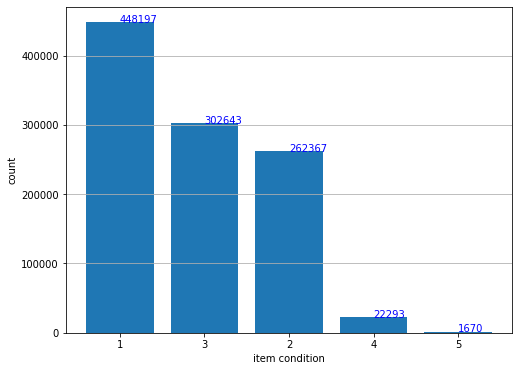

In [15]:
condition_count = Counter(list(train.item_condition_id))
x, y = zip(*condition_count.most_common())
plt.figure(figsize=[8,6])
plt.bar(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (x[i], y[i]), color='b')
plt.xlabel('item condition')
plt.ylabel('count')
plt.grid(True, axis='y')
plt.show()

In [16]:
train.brand_name.describe()

count     1037170
unique       4413
top       missing
freq       442715
Name: brand_name, dtype: object

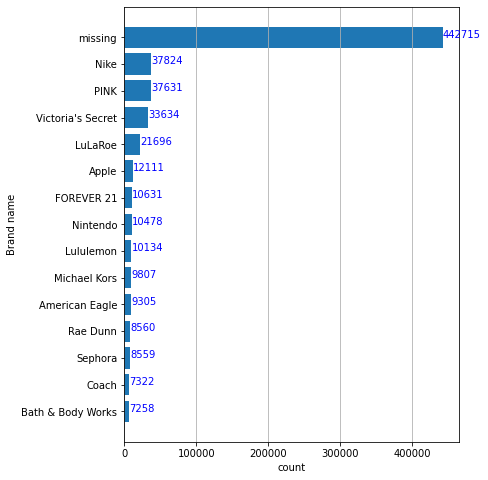

In [17]:
brand_count = Counter(list(train.brand_name.values))
x, y = zip(*brand_count.most_common(15))

plt.figure(figsize=[6,8])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('Brand name')
plt.xlabel('count')
plt.grid(True, axis='x')
plt.show()

In [18]:
brand_missing = train[train.brand_name=='missing'].shape[0]
print('Brand name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(brand_missing, 100.0*brand_missing/train.shape[0]))

Brand name is missing for 442715 datapoints, i.e. 42.68 % of train data.


In [19]:
train.gencat_name.describe()

count     1037170
unique         11
top         Women
freq       464350
Name: gencat_name, dtype: object

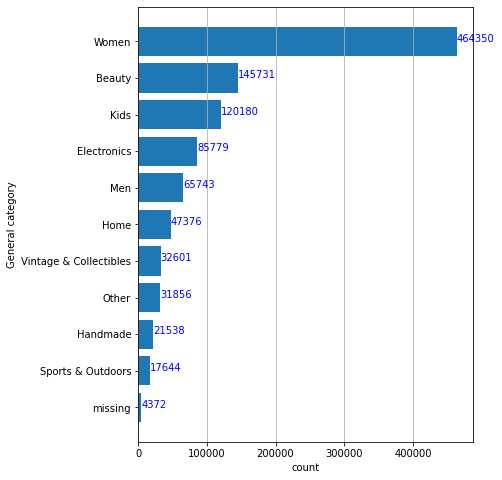

In [20]:
gencat_count = Counter(list(train.gencat_name.values))
x, y = zip(*gencat_count.most_common(15))
plt.figure(figsize=[6,8])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('General category')
plt.xlabel('count')
plt.grid(True, axis='x')
plt.show()

In [21]:
gencat_missing = train[train.gencat_name=='missing'].shape[0]
print('category name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(gencat_missing, 100.0*gencat_missing/train.shape[0]))

category name is missing for 4372 datapoints, i.e. 0.42 % of train data.


In [22]:
train.subcat1_name.describe()

count              1037170
unique                 114
top       Athletic Apparel
freq                 93933
Name: subcat1_name, dtype: object

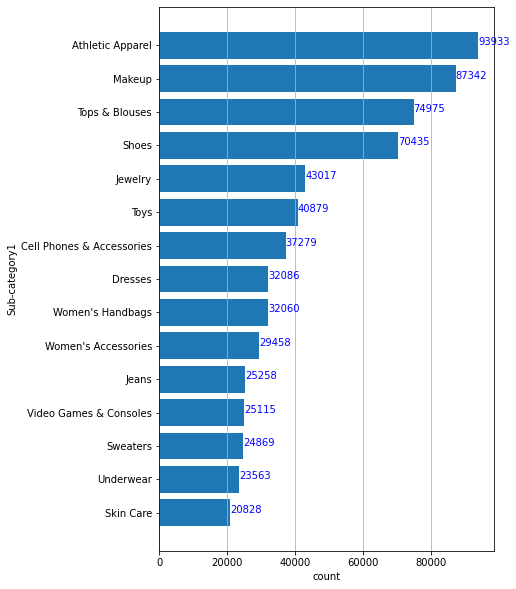

In [23]:
subcat1_count = Counter(list(train.subcat1_name.values))
x, y = zip(*subcat1_count.most_common(15))
plt.figure(figsize=[6,10])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('Sub-category1')
plt.xlabel('count')
plt.grid(True, axis='x')
plt.show()

In [24]:
train.subcat2_name.describe()

count                     1037170
unique                        857
top       Pants, Tights, Leggings
freq                        42032
Name: subcat2_name, dtype: object

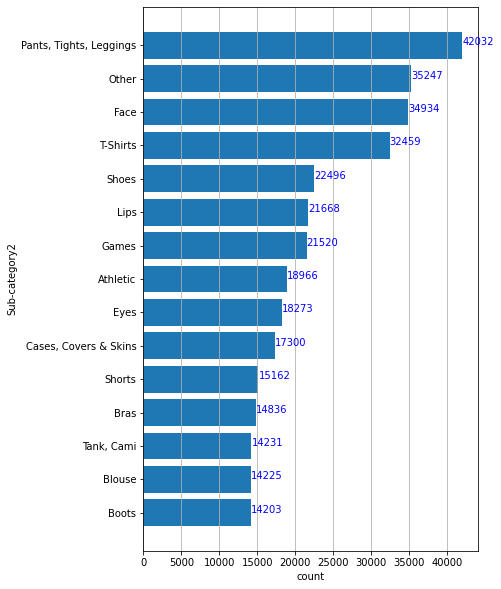

In [25]:
subcat2_count = Counter(list(train.subcat2_name.values))
x, y = zip(*subcat2_count.most_common(15))
plt.figure(figsize=[6,10])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('Sub-category2')
plt.xlabel('count')
plt.grid(True, axis='x')
plt.show()

In [26]:
desc_missing = train[train.item_description=='missing'].shape[0]
print('item description is missing for {} datapoints, i.e. {:.5f} % of train data.' .format(desc_missing, 100.0*desc_missing/train.shape[0]))

item description is missing for 2 datapoints, i.e. 0.00019 % of train data.


In [27]:
train[train.item_description=='missing']

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,gencat_name,subcat1_name,subcat2_name
61467,1224924,Disney Minnie Head band,3,Disney,9.0,0,missing,Women,Women's Accessories,Hair Accessories
589297,1264242,For Bianca,3,missing,10.0,1,missing,Women,Women's Accessories,Scarves & Wraps


In [28]:
train.price.describe()

count    1.037170e+06
mean     2.675051e+01
std      3.862636e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.004000e+03
Name: price, dtype: float64

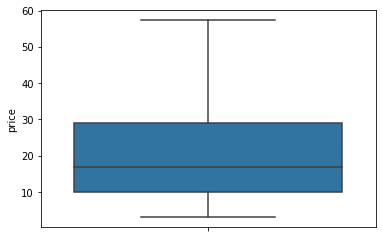

In [29]:
sns.boxplot(y='price', data=train, showfliers=False)
plt.show()

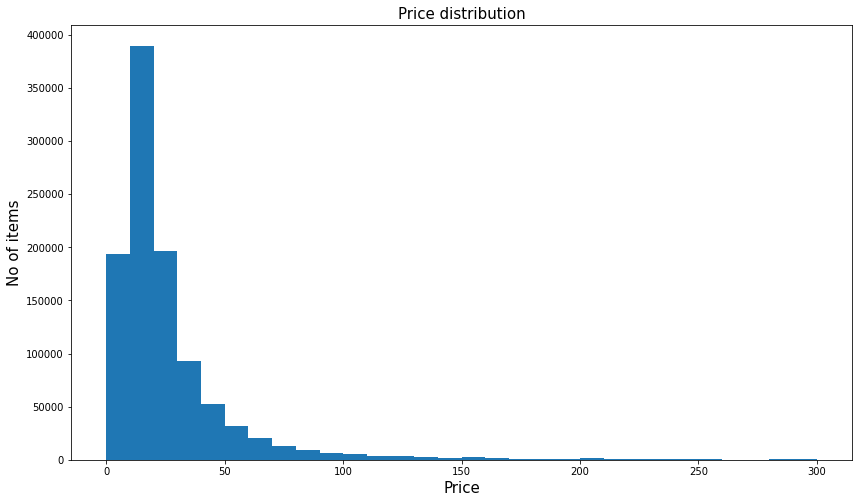

In [30]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.hist(train.price, bins=30, range=[0, 300], label="Price")
plt.title('Price distribution', fontsize = 15)
ax.set_xlabel('Price', fontsize=15)
ax.set_ylabel('No of items', fontsize=15)
plt.show()

In [31]:
def clean_cat(cat_values):
    
    catogories = list(cat_values)

    cat_list = []
    for i in (catogories):
        i = re.sub('[^A-Za-z0-9]+', ' ', i)
        i = i.replace(' ','')
        i = i.replace('&','_')
        cat_list.append(i.strip())
    
    return cat_list

In [32]:
train['gencat_name'] = clean_cat(train['gencat_name'].values)
test['gencat_name'] = clean_cat(test['gencat_name'].values)

train['subcat1_name'] = clean_cat(train['subcat1_name'].values)
test['subcat1_name'] = clean_cat(test['subcat1_name'].values)

train['subcat2_name'] = clean_cat(train['subcat2_name'].values)
test['subcat2_name'] = clean_cat(test['subcat2_name'].values)

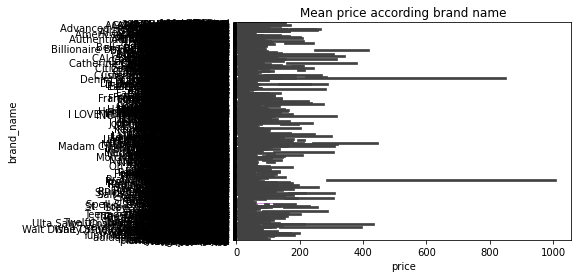

In [33]:
sns.barplot(y='brand_name', x='price', data=train)
plt.title('Mean price according brand name')
plt.show()

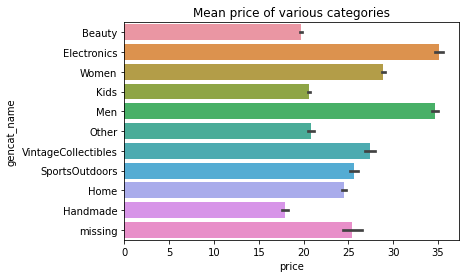

In [34]:
sns.barplot(y='gencat_name', x='price', data=train)
plt.title('Mean price of various categories')
plt.show()

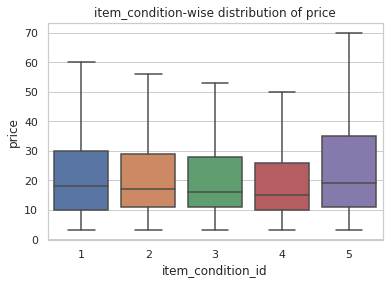

In [35]:
sns.set(style='whitegrid')
sns.boxplot(x='item_condition_id', y='price', data=train, showfliers=False)
plt.title('item_condition-wise distribution of price')
plt.show()

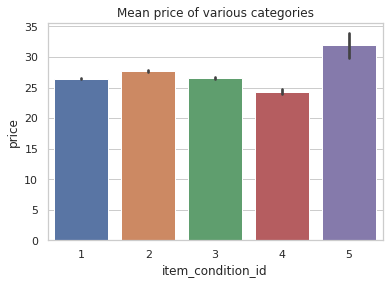

In [36]:
sns.barplot(y='price', x='item_condition_id', data=train)
plt.title('Mean price of various categories')
plt.show()

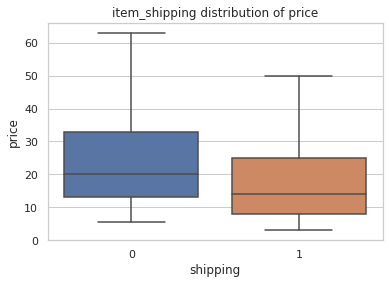

In [37]:
sns.set(style='whitegrid')
sns.boxplot(x='shipping', y='price', data=train, showfliers=False)
plt.title('item_shipping distribution of price')
plt.show()

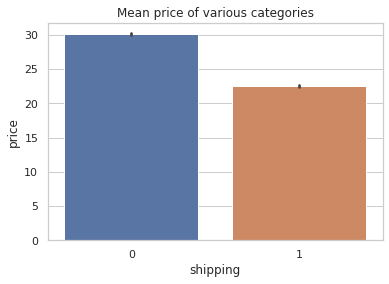

In [38]:
sns.barplot(y='price', x='shipping', data=train)
plt.title('Mean price of various categories')
plt.show()

In [39]:
train['name'].str.lower()

0          tarte rainforest after dark colored clay
1                        mac mineralize skin finish
2                            white case iphone 6/6s
3                  victoria's secret push-up plunge
4             disney princess toddler boots size 10
                             ...                   
1037165                     nike dri fit hooded top
1037166                       talk red hunter boots
1037167     nwt free ship cc 2beanie hat beige+taup
1037168                        winston cup snapback
1037169           old navy rockstar skinny cords 10
Name: name, Length: 1037170, dtype: object

In [40]:
test['name'].str.lower()

0                       herschel retreat backpack
1                               2 pairs of lebron
2          mario kart double dash with bonus disc
3          tokidoki unicorno kaiju and strawberry
4              like ugg cardy, grey knit top boot
                           ...                   
444756                         ivory ella tie dye
444757                      5 tier shoe organizer
444758    toy bundle (fun fun fun fun fun 4 baby)
444759                        adidas jogging suit
444760                           artistry hydra-v
Name: name, Length: 444761, dtype: object

In [41]:
test['item_description'].str.lower()
test['item_description'].str.lower()

0         in great condition! only issue is magnet that ...
1         lebron soldier 10 size 10.5 9/10 condition leb...
2                                good shape work no problem
3                               both new with foil and box.
4         brand new, not even a foot near them! size 8 b...
                                ...                        
444756    tags- american eagle, aeropostale, hollister, ...
444757    5 tier shoe organizer brand new never used 100...
444758    includes: fisher-price cozy fit tummy wedge ~ ...
444759    women comfortable adidas 2pc jogging suit incl...
444760                         full and great for your skin
Name: item_description, Length: 444761, dtype: object

In [42]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')


def preprocess_text(text_col):
    preprocessed_text = []
    for sentence in tqdm((text_col.values)):
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
train['preprocessed_name'] = preprocess_text(train['name'])
test['preprocessed_name'] = preprocess_text(test['name'])

train['preprocessed_description'] = preprocess_text(train['item_description'])
test['preprocessed_description'] = preprocess_text(test['item_description'])

100%|██████████| 444761/444761 [00:26<00:00, 17070.26it/s]


In [44]:
train['name_len'] = train['name'].apply(lambda x: len(x))
train['des_len'] = train['item_description'].apply(lambda x: len(x))
train['desc_word_count'] = train['item_description'].apply(lambda x: len(x.split()))
train['name_word_count'] = train['name'].apply(lambda x: len(x.split()))
train['desc_letters_per_word'] = train['des_len'] / train['desc_word_count']
train['name_letters_per_word'] = train['name_len'] / train['name_word_count']
train['price_in_description'] = train['item_description'].str.contains('[rm]', regex=False).astype('category')
train['price_in_name'] = train['name'].str.contains('[rm]', regex=False).astype('category')

In [45]:
test['name_len'] = test['name'].apply(lambda x: len(x))
test['des_len'] = test['item_description'].apply(lambda x: len(x))
test['desc_word_count'] = test['item_description'].apply(lambda x: len(x.split()))
test['name_word_count'] = test['name'].apply(lambda x: len(x.split()))
test['desc_letters_per_word'] = test['des_len'] / test['desc_word_count']
test['name_letters_per_word'] = test['name_len'] / test['name_word_count']
test['price_in_description'] = test['item_description'].str.contains('[rm]', regex=False).astype('category')
test['price_in_name'] = test['name'].str.contains('[rm]', regex=False).astype('category')

In [46]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'brand_name', 'price',
       'shipping', 'item_description', 'gencat_name', 'subcat1_name',
       'subcat2_name', 'preprocessed_name', 'preprocessed_description',
       'name_len', 'des_len', 'desc_word_count', 'name_word_count',
       'desc_letters_per_word', 'name_letters_per_word',
       'price_in_description', 'price_in_name'],
      dtype='object')

In [47]:
train.shape
train.columns

Index(['train_id', 'name', 'item_condition_id', 'brand_name', 'price',
       'shipping', 'item_description', 'gencat_name', 'subcat1_name',
       'subcat2_name', 'preprocessed_name', 'preprocessed_description',
       'name_len', 'des_len', 'desc_word_count', 'name_word_count',
       'desc_letters_per_word', 'name_letters_per_word',
       'price_in_description', 'price_in_name'],
      dtype='object')

In [48]:
test.shape


(444761, 19)

In [49]:
n_rows = train.shape[0]
train = train[train.preprocessed_name != ''].reset_index(drop=True)

print('Dropped {} rows'.format(n_rows - train.shape[0]))

Dropped 19 rows


In [50]:
n_rows = train.shape[0]
train = train[train.preprocessed_description != ''].reset_index(drop=True)

print('Dropped {} rows'.format(n_rows - train.shape[0]))

print('Shape of train data: ', train.shape)

Dropped 392 rows
Shape of train data:  (1036759, 20)


In [51]:
def transform_test(base_col, feat_col):
    
    di = pd.Series(train[feat_col].values, index=train[base_col].values).to_dict()
    
    if base_col == 'item_condition_id':
        return test[base_col].map(di).astype(float)
        
    return test[base_col].map(di).fillna(0)

In [52]:
train['brand_mean_price'] = train.groupby('brand_name')['price'].transform('mean')
test['brand_mean_price'] = transform_test('brand_name', 'brand_mean_price')

train['gencat_mean_price'] = train.groupby('gencat_name')['price'].transform('mean')
test['gencat_mean_price'] = transform_test('gencat_name', 'gencat_mean_price')

train['subcat1_mean_price'] = train.groupby('subcat1_name')['price'].transform('mean')
test['subcat1_mean_price'] = transform_test('subcat1_name', 'subcat1_mean_price')

train['subcat2_mean_price'] = train.groupby('subcat2_name')['price'].transform('mean')
test['subcat2_mean_price'] = transform_test('subcat2_name', 'subcat2_mean_price')

train['condition_mean_price'] = train.groupby('item_condition_id')['price'].transform('mean')
test['condition_mean_price'] = transform_test('item_condition_id', 'condition_mean_price')

In [53]:
train['brand_median_price'] = train.groupby('brand_name')['price'].transform('median')
test['brand_median_price'] = transform_test('brand_name', 'brand_median_price')

train['gencat_median_price'] = train.groupby('gencat_name')['price'].transform('median')
test['gencat_median_price'] = transform_test('gencat_name', 'gencat_median_price')

train['subcat1_median_price'] = train.groupby('subcat1_name')['price'].transform('median')
test['subcat1_median_price'] = transform_test('subcat1_name', 'subcat1_median_price')

train['subcat2_median_price'] = train.groupby('subcat2_name')['price'].transform('median')
test['subcat2_median_price'] = transform_test('subcat2_name', 'subcat2_median_price')

train['condition_median_price'] = train.groupby('item_condition_id')['price'].transform('median')
test['condition_median_price'] = transform_test('item_condition_id', 'condition_median_price')

In [54]:
train['gencat_name_count'] = train.groupby('gencat_name')['gencat_name'].transform('count')
test['gencat_name_count'] = transform_test('gencat_name', 'gencat_name_count')

train['subcat1_name_count'] = train.groupby('subcat1_name')['subcat1_name'].transform('count')
test['subcat1_name_count'] = transform_test('subcat1_name', 'subcat1_name_count')

train['subcat2_name_count'] = train.groupby('subcat2_name')['subcat2_name'].transform('count')
test['subcat2_name_count'] = transform_test('subcat2_name', 'subcat2_name_count')

train['brand_name_count'] = train.groupby('brand_name')['brand_name'].transform('count')
test['brand_name_count'] = transform_test('brand_name', 'brand_name_count')

In [55]:
test.drop(['name', 'item_description'], axis=1, inplace=True)
train.drop(['name', 'item_description'], axis=1, inplace=True)

In [56]:
train.shape

(1036759, 32)

In [57]:
test.shape

(444761, 31)

In [58]:
from sklearn.model_selection import train_test_split

y_tr = np.log1p(train['price'])
train.drop(['price'], axis=1, inplace=True)

train_df, cv_df , y_train, y_cv = train_test_split(train, y_tr, test_size=0.15, random_state=56)

print('Train size: {}, CV size: {}, Test size: {}' .format(train_df.shape, cv_df.shape, test.shape))

Train size: (881245, 31), CV size: (155514, 31), Test size: (444761, 31)


In [59]:
#del train, y_tr 
#gc.collect()

In [60]:
train_df['brand_name'] = clean_cat(train_df['brand_name'].values)
cv_df['brand_name'] = clean_cat(cv_df['brand_name'].values)
test['brand_name'] = clean_cat(test['brand_name'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_brand_oneHot = vectorizer.fit_transform(train_df['brand_name'].values)

cv_brand_oneHot = vectorizer.transform(cv_df['brand_name'].values)
test_brand_oneHot = vectorizer.transform(test['brand_name'].values)

print("Shape of matrices after one hot encoding")
print(train_brand_oneHot.shape, "\n", cv_brand_oneHot.shape, "\n", test_brand_oneHot.shape)

Shape of matrices after one hot encoding
(881245, 4188) 
 (155514, 4188) 
 (444761, 4188)


In [62]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_gencat_oneHot = vectorizer.fit_transform(train_df['gencat_name'].values)

cv_gencat_oneHot = vectorizer.transform(cv_df['gencat_name'].values)
test_gencat_oneHot = vectorizer.transform(test['gencat_name'].values)

print("Shape of matrices after one hot encoding")
print(train_gencat_oneHot.shape, "\n", cv_gencat_oneHot.shape, "\n", test_gencat_oneHot.shape)

Shape of matrices after one hot encoding
(881245, 11) 
 (155514, 11) 
 (444761, 11)


In [63]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_subcat1_oneHot = vectorizer.fit_transform(train_df['subcat1_name'].values)

cv_subcat1_oneHot = vectorizer.transform(cv_df['subcat1_name'].values)
test_subcat1_oneHot = vectorizer.transform(test['subcat1_name'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat1_oneHot.shape, "\n", cv_subcat1_oneHot.shape, "\n", test_subcat1_oneHot.shape)

Shape of matrices after one hot encoding
(881245, 114) 
 (155514, 114) 
 (444761, 114)


In [64]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_subcat2_oneHot = vectorizer.fit_transform(train_df['subcat2_name'].values)

cv_subcat2_oneHot = vectorizer.transform(cv_df['subcat2_name'].values)
test_subcat2_oneHot = vectorizer.transform(test['subcat2_name'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat2_oneHot.shape, "\n", cv_subcat2_oneHot.shape, "\n", test_subcat2_oneHot.shape)

Shape of matrices after one hot encoding
(881245, 842) 
 (155514, 842) 
 (444761, 842)


In [65]:
def concat_feature_text(df: pd.DataFrame):
    df['preprocessed_name'] = df['preprocessed_name'].fillna('') + ' ' + df['brand_name'].fillna('')
    df['preprocessed_description'] = df['preprocessed_description'].fillna('') + ' ' + df['preprocessed_name'] + ' ' + df['subcat2_name'].fillna('')

In [66]:
concat_feature_text(train_df)
concat_feature_text(cv_df)
concat_feature_text(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3, max_features=250000)

train_name_tfidf = vectorizer.fit_transform(train_df['preprocessed_name'].values)

cv_name_tfidf = vectorizer.transform(cv_df['preprocessed_name'].values)
test_name_tfidf = vectorizer.transform(test['preprocessed_name'].values)

print("Shape of matrices after vectorization")
print(train_name_tfidf.shape, "\n", cv_name_tfidf.shape, "\n", test_name_tfidf.shape)

Shape of matrices after vectorization
(881245, 250000) 
 (155514, 250000) 
 (444761, 250000)


In [68]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=5, max_features=500000)

train_description_tfidf = vectorizer.fit_transform(train_df['preprocessed_description'].values)

cv_description_tfidf = vectorizer.transform(cv_df['preprocessed_description'].values)
test_description_tfidf = vectorizer.transform(test['preprocessed_description'].values)

print("Shape of matrices after vectorization")
print(train_description_tfidf.shape, "\n", cv_description_tfidf.shape, "\n", test_description_tfidf.shape)

Shape of matrices after vectorization
(881245, 500000) 
 (155514, 500000) 
 (444761, 500000)


In [69]:
submission_df = pd.DataFrame(test['id'])
print(submission_df.shape)
submission_df.head()

(444761, 1)


,id
0,1048243
1,86986
2,698316
3,268868
4,1360398


In [70]:
train_df.columns

Index(['train_id', 'item_condition_id', 'brand_name', 'shipping',
       'gencat_name', 'subcat1_name', 'subcat2_name', 'preprocessed_name',
       'preprocessed_description', 'name_len', 'des_len', 'desc_word_count',
       'name_word_count', 'desc_letters_per_word', 'name_letters_per_word',
       'price_in_description', 'price_in_name', 'brand_mean_price',
       'gencat_mean_price', 'subcat1_mean_price', 'subcat2_mean_price',
       'condition_mean_price', 'brand_median_price', 'gencat_median_price',
       'subcat1_median_price', 'subcat2_median_price',
       'condition_median_price', 'gencat_name_count', 'subcat1_name_count',
       'subcat2_name_count', 'brand_name_count'],
      dtype='object')

In [71]:
cols = set(train_df.columns.values) - {'train_id'}
skip_cols = {'preprocessed_name', 'item_condition_id', 'brand_name',
  'shipping', 'preprocessed_description', 'gencat_name',
  'subcat1_name', 'subcat2_name', 'price_in_name', 'price_in_description'}

cols_to_normalize = cols - skip_cols
print("Normalizing following columns: ", cols_to_normalize)

def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (feature_name in cols_to_normalize):
            print(feature_name)
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

Normalizing following columns:  {'condition_median_price', 'subcat2_median_price', 'brand_name_count', 'subcat2_name_count', 'name_letters_per_word', 'condition_mean_price', 'subcat2_mean_price', 'subcat1_mean_price', 'gencat_name_count', 'name_word_count', 'desc_word_count', 'gencat_median_price', 'desc_letters_per_word', 'name_len', 'gencat_mean_price', 'brand_mean_price', 'subcat1_name_count', 'brand_median_price', 'subcat1_median_price', 'des_len'}


In [72]:
train_df.columns

Index(['train_id', 'item_condition_id', 'brand_name', 'shipping',
       'gencat_name', 'subcat1_name', 'subcat2_name', 'preprocessed_name',
       'preprocessed_description', 'name_len', 'des_len', 'desc_word_count',
       'name_word_count', 'desc_letters_per_word', 'name_letters_per_word',
       'price_in_description', 'price_in_name', 'brand_mean_price',
       'gencat_mean_price', 'subcat1_mean_price', 'subcat2_mean_price',
       'condition_mean_price', 'brand_median_price', 'gencat_median_price',
       'subcat1_median_price', 'subcat2_median_price',
       'condition_median_price', 'gencat_name_count', 'subcat1_name_count',
       'subcat2_name_count', 'brand_name_count'],
      dtype='object')

In [73]:
train_normalized = normalize(train_df)
cv_normalized = normalize(cv_df)
test_normalized = normalize(test)

name_len
des_len
desc_word_count
name_word_count
desc_letters_per_word
name_letters_per_word
brand_mean_price
gencat_mean_price
subcat1_mean_price
subcat2_mean_price
condition_mean_price
brand_median_price
gencat_median_price
subcat1_median_price
subcat2_median_price
condition_median_price
gencat_name_count
subcat1_name_count
subcat2_name_count
brand_name_count
name_len
des_len
desc_word_count
name_word_count
desc_letters_per_word
name_letters_per_word
brand_mean_price
gencat_mean_price
subcat1_mean_price
subcat2_mean_price
condition_mean_price
brand_median_price
gencat_median_price
subcat1_median_price
subcat2_median_price
condition_median_price
gencat_name_count
subcat1_name_count
subcat2_name_count
brand_name_count
name_len
des_len
desc_word_count
name_word_count
desc_letters_per_word
name_letters_per_word
brand_mean_price
gencat_mean_price
subcat1_mean_price
subcat2_mean_price
condition_mean_price
brand_median_price
gencat_median_price
subcat1_median_price
subcat2_median_price
cond

In [74]:

X_tr = train_normalized[list(cols_to_normalize)]
X_val = cv_normalized[list(cols_to_normalize)]
X_te = test_normalized[list(cols_to_normalize)]

X_tr.head(2)

,condition_median_price,subcat2_median_price,brand_name_count,subcat2_name_count,name_letters_per_word,condition_mean_price,subcat2_mean_price,subcat1_mean_price,gencat_name_count,name_word_count,desc_word_count,gencat_median_price,desc_letters_per_word,name_len,gencat_mean_price,brand_mean_price,subcat1_name_count,brand_median_price,subcat1_median_price,des_len
268131,0.75,0.113725,1.000000,0.00802,0.106227,0.279897,0.101357,0.116826,0.307329,0.461538,0.028689,0.333333,0.025000,0.833333,0.103814,0.028220,0.058083,0.017121,0.264706,0.057416
971433,0.75,0.074510,0.006383,0.06409,0.145299,0.279897,0.077406,0.620983,1.000000,0.384615,0.069672,0.777778,0.023899,0.928571,0.638601,0.031099,0.341223,0.024903,0.735294,0.125359


In [75]:
#del train_df, cv_df, test
#gc.collect()

In [76]:
from scipy.sparse import csr_matrix

X_tr_cat = csr_matrix(pd.get_dummies(train_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True).values)

X_cv_cat = csr_matrix(pd.get_dummies(cv_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True).values)

X_te_cat = csr_matrix(pd.get_dummies(test_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True).values)

print(X_tr_cat.shape, X_cv_cat.shape, X_te_cat.shape)

(881245, 9) (155514, 9) (444761, 9)


In [77]:
from scipy.sparse import hstack

train_sparse = hstack((train_brand_oneHot, train_gencat_oneHot, train_subcat1_oneHot, train_subcat2_oneHot, \
               train_name_tfidf, train_description_tfidf, X_tr_cat)).tocsr()

cv_sparse = hstack((cv_brand_oneHot, cv_gencat_oneHot, cv_subcat1_oneHot, cv_subcat2_oneHot, \
               cv_name_tfidf, cv_description_tfidf, X_cv_cat)).tocsr()

test_sparse = hstack((test_brand_oneHot, test_gencat_oneHot, test_subcat1_oneHot, test_subcat2_oneHot, \
               test_name_tfidf, test_description_tfidf, X_te_cat)).tocsr()

In [78]:
print(train_sparse.shape, cv_sparse.shape, test_sparse.shape)

(881245, 755164) (155514, 755164) (444761, 755164)


In [79]:

X_train = hstack((X_tr.values, train_sparse)).tocsr()

X_cv = hstack((X_val.values, cv_sparse)).tocsr()

X_test = hstack((X_te.values, test_sparse)).tocsr()

In [80]:
print('Train size: {}, CV size: {}, Test size: {}' .format(X_train.shape, X_cv.shape, X_test.shape))

Train size: (881245, 755184), CV size: (155514, 755184), Test size: (444761, 755184)


In [81]:
"""
alpha = [1, 2, 3, 3.5, 4, 4.5, 5, 6, 7] 
cv_rmsle_array=[] 
for i in tqdm(alpha):
    model = Ridge(solver="sag", random_state=56, alpha=i)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_rmsle_array.append(sqrt(mse(y_cv, preds_cv)))

for i in range(len(cv_rmsle_array)):
    print ('RMSLE for alpha = ',alpha[i],'is',cv_rmsle_array[i])
    
best_alpha = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_rmsle_array)
ax.scatter(alpha, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_rmsle_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()
"""

'\nalpha = [1, 2, 3, 3.5, 4, 4.5, 5, 6, 7] \ncv_rmsle_array=[] \nfor i in tqdm(alpha):\n    model = Ridge(solver="sag", random_state=56, alpha=i)\n    model.fit(X_train, y_train)\n    preds_cv = model.predict(X_cv)\n    cv_rmsle_array.append(sqrt(mse(y_cv, preds_cv)))\n\nfor i in range(len(cv_rmsle_array)):\n    print (\'RMSLE for alpha = \',alpha[i],\'is\',cv_rmsle_array[i])\n    \nbest_alpha = np.argmin(cv_rmsle_array)\n\nfig, ax = plt.subplots()\nax.plot(alpha, cv_rmsle_array)\nax.scatter(alpha, cv_rmsle_array)\nfor i, txt in enumerate(np.round(cv_rmsle_array,3)):\n    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_rmsle_array[i]))\n\nplt.title("Cross Validation Error for each alpha")\nplt.xlabel("Alpha")\nplt.ylabel("Error")\nplt.show()\n'

In [82]:
"""
print("Best alpha: ",  alpha[best_alpha])
model = Ridge(solver="sag", random_state=56, alpha=alpha[best_alpha])
model.fit(X_train, y_train)
ridge_preds_tr = model.predict(X_train)
ridge_preds_cv = model.predict(X_cv)
ridge_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mse(y_train, ridge_preds_tr)))

ridge_rmsle = sqrt(mse(y_cv, ridge_preds_cv))
print("Cross validation RMSLE: ", ridge_rmsle)
"""

'\nprint("Best alpha: ",  alpha[best_alpha])\nmodel = Ridge(solver="sag", random_state=56, alpha=alpha[best_alpha])\nmodel.fit(X_train, y_train)\nridge_preds_tr = model.predict(X_train)\nridge_preds_cv = model.predict(X_cv)\nridge_preds_te = model.predict(X_test)\n\nprint(\'Train RMSLE:\', sqrt(mse(y_train, ridge_preds_tr)))\n\nridge_rmsle = sqrt(mse(y_cv, ridge_preds_cv))\nprint("Cross validation RMSLE: ", ridge_rmsle)\n'

In [83]:
"""
submission_df['price'] = np.exp(ridge_preds_te) - 1

submission_df.to_csv('ridge_submission_colab.csv', index=False)
"""

"\nsubmission_df['price'] = np.exp(ridge_preds_te) - 1\n\nsubmission_df.to_csv('ridge_submission_colab.csv', index=False)\n"

In [84]:
#print("Best alpha: ",  alpha[best_alpha])
model = Ridge(solver="sag", random_state=56, alpha=2.5)
model.fit(X_train, y_train)
ridge_preds_tr = model.predict(X_train)
ridge_preds_cv = model.predict(X_cv)
ridge_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mse(y_train, ridge_preds_tr)))

ridge_rmsle = sqrt(mse(y_cv, ridge_preds_cv))
print("Cross validation RMSLE: ", ridge_rmsle)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


Train RMSLE: 0.35721927416013455
Cross validation RMSLE:  0.4517812813340723


In [85]:
submission_df['price'] = np.exp(ridge_preds_te) - 1

submission_df.to_csv('ridge_submission_colab.csv', index=False)

In [86]:
  # import scipy
  # scipy.sparse.save_npz("cv_final.npz", X_cv)
  # np.save('y_cv', y_cv)

In [87]:
  # scipy.sparse.save_npz("train_final.npz", X_train)
  # np.save('y_train', y_train)

In [88]:
# scipy.sparse.save_npz("test_final.npz", X_test)

In [89]:
""""
X_train_saved = scipy.sparse.load_npz("train_final.npz")
y_train_saved = np.load('y_train.npy')

X_cv_saved = scipy.sparse.load_npz("cv_final.npz")
y_cv_saved = np.load('y_cv.npy')

X_test_saved = scipy.sparse.load_npz("test_final.npz")
X_train_saved.shape, y_train_saved.shape, X_cv_saved.shape, y_cv_saved.shape, X_test_saved.shape 
"""

'"\nX_train_saved = scipy.sparse.load_npz("train_final.npz")\ny_train_saved = np.load(\'y_train.npy\')\n\nX_cv_saved = scipy.sparse.load_npz("cv_final.npz")\ny_cv_saved = np.load(\'y_cv.npy\')\n\nX_test_saved = scipy.sparse.load_npz("test_final.npz")\nX_train_saved.shape, y_train_saved.shape, X_cv_saved.shape, y_cv_saved.shape, X_test_saved.shape \n'

In [90]:
# np.save('ridge_preds_tr', ridge_preds_tr)
# np.save('ridge_preds_cv', ridge_preds_cv)
# np.save('ridge_preds_te', ridge_preds_te)
# np.save('train_sparse',train_sparse) 
# np.save('cv_sparse', cv_sparse)
# np.save('test_sparse',test_sparse)

In [91]:
# from lightgbm import LGBMRegressor
# lgbm_regressor=LGBMRegressor(learning_rate=0.4,max_depth=10,n_estimators=500,num_leaves=100,boosting_type='gbdt',colsample_bytree=0.8,min_child_samples=50)
# lgbm_regressor.fit(X_train,y_train)

In [92]:
# ytrain_predict_lgbm=lgbm_regressor.predict(X_train)
# ycv_predict_lgbm=lgbm_regressor.predict(X_cv)
# training = np.sqrt(mean_squared_error(y_train, ytrain_predict_lgbm))
# cving=np.sqrt(mean_squared_error(y_cv,ycv_predict_lgbm))
# print("RMSLE of train is {} RMSLE of test is {}".format(training,cving))
# ytest_lgbm=lgbm_regressor.predict(X_test)

In [93]:
# submission_df['price'] = np.exp(ytest_lgbm) - 1
# submission_df.to_csv('lgbm_submission_colab.csv', index=False)

In [94]:


from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=0.01)
model.fit(X_train, y_train>= 4)

mnb_preds_tr = model.predict_proba(X_train)[:, 1]
mnb_preds_cv = model.predict_proba(X_cv)[:, 1]
mnb_preds_te = model.predict_proba(X_test)[:, 1]


In [95]:
from sklearn.feature_selection.univariate_selection import SelectKBest, f_regression

fselect = SelectKBest(f_regression, k=48000)
train_features = fselect.fit_transform(train_sparse, y_train)

cv_features = fselect.transform(cv_sparse)
test_features = fselect.transform(test_sparse)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [96]:
# stack feature matrix with Ridge, MNB model predictions, engineered features
X_train = hstack((X_tr.values, ridge_preds_tr.reshape(-1,1), mnb_preds_tr.reshape(-1,1), train_features)).tocsr()

X_cv = hstack((X_val.values, ridge_preds_cv.reshape(-1,1), mnb_preds_cv.reshape(-1,1), cv_features)).tocsr()

X_test = hstack((X_te.values, ridge_preds_te.reshape(-1,1), mnb_preds_te.reshape(-1,1), test_features)).tocsr()

print('Train size: {}, CV size: {}, Test size: {}' .format(X_train.shape, X_cv.shape, X_test.shape))

Train size: (881245, 48022), CV size: (155514, 48022), Test size: (444761, 48022)


In [97]:
"""
c_param = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4]
cv_rmsle_array=[]

for i in c_param:
    model = SVR(C=i, max_iter=200)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_err = sqrt(mse(y_cv, preds_cv))
    cv_rmsle_array.append(cv_err)

    print('RMSLE for C=',i, 'is', cv_err)

best_C = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(c_param, cv_rmsle_array)
ax.scatter(c_param, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((c_param[i],np.round(txt,3)), (c_param[i],cv_rmsle_array[i]))
plt.title("Cross Validation Error for each C")
plt.xlabel("C")
plt.ylabel("Error")
plt.show()
"""

'\nc_param = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4]\ncv_rmsle_array=[]\n\nfor i in c_param:\n    model = SVR(C=i, max_iter=200)\n    model.fit(X_train, y_train)\n    preds_cv = model.predict(X_cv)\n    cv_err = sqrt(mse(y_cv, preds_cv))\n    cv_rmsle_array.append(cv_err)\n\n    print(\'RMSLE for C=\',i, \'is\', cv_err)\n\nbest_C = np.argmin(cv_rmsle_array)\n\nfig, ax = plt.subplots()\nax.plot(c_param, cv_rmsle_array)\nax.scatter(c_param, cv_rmsle_array)\nfor i, txt in enumerate(np.round(cv_rmsle_array,3)):\n    ax.annotate((c_param[i],np.round(txt,3)), (c_param[i],cv_rmsle_array[i]))\nplt.title("Cross Validation Error for each C")\nplt.xlabel("C")\nplt.ylabel("Error")\nplt.show()\n'

In [98]:
from sklearn.svm import SVR
best_C = 0.2
print('Best C: ', best_C)
model = SVR(C=best_C, max_iter=200)
model.fit(X_train, y_train)

Best C:  0.2


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVR(C=0.2, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=200, shrinking=True, tol=0.001, verbose=False)

In [99]:
svr_preds_tr = model.predict(X_train)
svr_preds_cv = model.predict(X_cv)
print('Train RMSLE:', sqrt(mse(y_train, svr_preds_tr)))

svr_rmsle = sqrt(mse(y_cv, svr_preds_cv))
print("Cross validation RMSLE: ", svr_rmsle)

Train RMSLE: 0.4085402597404695
Cross validation RMSLE:  0.4488255239288679


In [100]:
submission_df_svr = pd.DataFrame(test['id'])
svr_preds_te = model.predict(X_test)
submission_df_svr['price'] = np.exp(svr_preds_te) - 1
submission_df_svr.to_csv('svr_submission_colab.csv', index=False)
submission_df_svr.head()

,id,price
0,1048243,34.453731
1,86986,47.294192
2,698316,20.431827
3,268868,14.767620
4,1360398,27.204126


In [101]:
svr_preds_tr.shape

(881245,)

In [110]:
stack_train = np.vstack((svr_preds_tr, ridge_preds_tr)).T

In [102]:
ridge_preds_tr.shape

(881245,)

In [111]:
stack_train.shape

(881245, 2)

In [113]:
from sklearn.linear_model import LinearRegression

In [114]:
lr = LinearRegression()

In [115]:
lr.fit(stack_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [119]:
test_stack_train = np.vstack((np.exp(svr_preds_te) -1, np.exp(ridge_preds_te) -1)).T

In [120]:
stack_predict = lr.predict(test_stack_train)

In [121]:
submission_df_stack = pd.DataFrame(test['id'])
submission_df_stack['price'] = stack_predict
submission_df_stack.to_csv('stack_submission_colab.csv', index=False)
submission_df_stack.head()

,id,price
0,1048243,44.068961
1,86986,59.140901
2,698316,29.449590
3,268868,21.331010
4,1360398,34.146904
